In [62]:
import iris
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from glob import glob
import seaborn as sns
import xesmf as xe
import pandas as pd
#import def_homebrew as hb ## homemade functions xox
from scipy.special import gamma
import netCDF4 as nc
import datetime

In [2]:
## where are the bloody files??

#path = '/gws/nopw/j04/dcmex/users/glloyd/'
#nc_name = '2DS_MAN_20220730_v001_r0_c307.nc'
#nc_file = nc.Dataset(path+nc_name,'r') # we are just looking at 1 day of flights

nc_file = nc.Dataset('2DS_MAN_20220730_v001_r0_c307.nc','r')

# the structure of these netcdfs are a nightmare, where the ch0 / ch1 are seperate groups and everything has to be accessed through them

In [3]:
## this function gets important bits from the netcdf -> (correct) time + index (particle diameter)
def important_bits(nc):
    time_var = nc.variables['time'][:]
    epoch_start = datetime.datetime(1970, 1, 1)
    datetime_values = [epoch_start + datetime.timedelta(seconds=float(time)) for time in time_var]

    index = nc.variables['ambient_particle_diameter'][:]
    return datetime_values, index

## function to extract specif variable (within ch0 / ch1 group) -> its own xr DataArray
## variable should be 2d - with time + index
def get_group_var(nc,ch_n,var_name,time_lst,idx_lst):
    var = nc[f'ch{ch_n}'][var_name]
    
    var_nc = xr.DataArray(var[:,:],
                          dims=['time', 'index'],  # Define dimensions
                          coords={'time': time_lst, 'index': idx_lst},  # Specify coords
                          attrs={key: var.getncattr(key) for key in var.ncattrs()})  # Copy attributes

    return var_nc
    

In [38]:
time, index = important_bits(nc_file)

## things of interest: ambient_*I_particle_number_per_channel, for HI / MI / LI in ch0 and ch1
hi_0 = get_group_var(nc_file,0,'ambient_HI_particle_number_per_channel',time, index)
hi_1 = get_group_var(nc_file,1,'ambient_HI_particle_number_per_channel',time, index)

mi_0 = get_group_var(nc_file,0,'ambient_MI_particle_number_per_channel',time, index)
mi_1 = get_group_var(nc_file,1,'ambient_MI_particle_number_per_channel',time, index)

li_0 = get_group_var(nc_file,0,'ambient_LI_particle_number_per_channel',time, index)
li_1 = get_group_var(nc_file,1,'ambient_LI_particle_number_per_channel',time, index)

hi_av = (hi_0 + hi_1)/2
mi_av = (mi_0 + mi_1)/2
li_av = (li_0 + li_1)/2

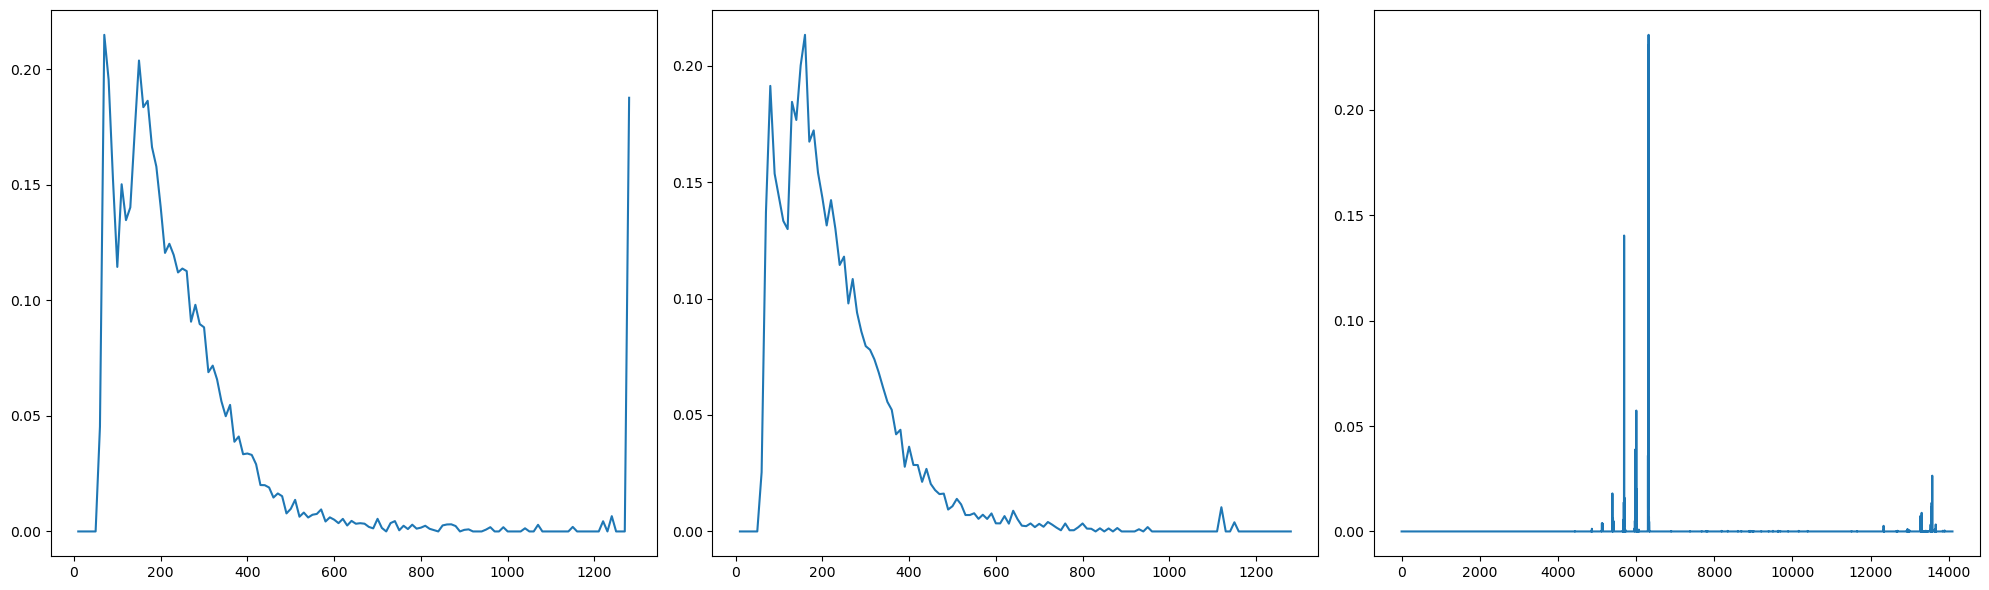

In [5]:
#simple = hi_0.sum(dim = 'index')
#plt.plot(simple)

#print(hi_0)
#print(hi_1)

average = (hi_0 + hi_1)/2 ## mean of two

h0 = hi_0.sum(dim = 'time')
h1 = hi_1.sum(dim = 'time')
av = average.sum(dim = 'time')            
#hi_0.sum(dim = 'time')
av1 = average.sum(dim = 'index')

plt.figure(figsize = (20,6))
plt.subplot(131)
plt.plot(h0)
plt.subplot(132)
plt.plot(h1)
plt.subplot(133)
plt.plot(av1)
plt.tight_layout()

In [6]:
time_s = hi_0.sum(dim = 'index')
dim = hi_0.sum(dim = 'time')
#plt.plot(simple)
#hi_0

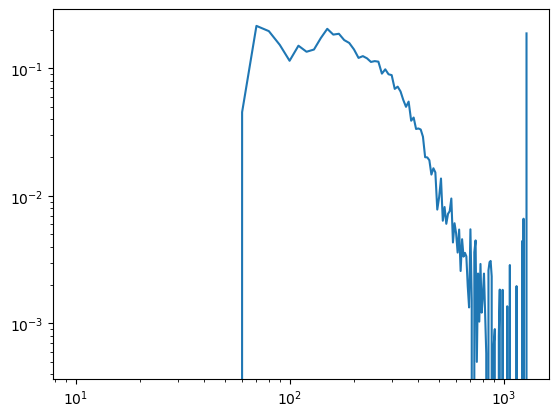

In [17]:
plt.plot(dim)
plt.yscale('log')
plt.xscale('log')

In [17]:
def extract_segments_with_value_greater_than_zero(data_array):
    segments = []
    segment_start = None
    for i, value in enumerate(data_array):
        if value > 0:
            if segment_start is None:
                segment_start = data_array.time[i]
        elif segment_start is not None:
            segments.append((segment_start, data_array.time[i-1]))
            segment_start = None
    if segment_start is not None:
        segments.append((segment_start, data_array.time[-1]))
    return segments

segments = extract_segments_with_value_greater_than_zero(time_s)
print("Segments with value > 0:")
for start, end in segments:
    print(f"Start: {start}, End: {end}")


def find_groups_of_values(data, threshold):
    groups = []
    start = data[0]
    for i in range(1, len(data)):
        if data[i] - data[i-1] > threshold:
            end = data[i-1]
            groups.append((start, end))
            start = data[i]
    groups.append((start, data[-1]))
    return groups

# Example usage
data = [4852, 4860, 4865, 4868, 4869, 4870, 5119, 5121, 5122, 5123, 5124, 5125, 5126, 5127, 5128, 5129, 5130, 5132, 5134, 5135, 5136, 5137, 5138, 5139, 5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149, 5150, 5151, 5152, 5391, 5392, 5393, 5394, 5395, 5396, 5397, 5398, 5403, 5404, 5405, 5406, 5408, 5409, 5411, 5412, 5413, 5414, 5415, 5416, 5417, 5418, 5419, 5420, 5421, 5422, 5423, 5424, 5425, 5426, 5427, 5428, 5429, 5430, 5660, 5663, 5668, 5671, 5677, 5678, 5679, 5680, 5681, 5684, 5685, 5686, 5687, 5688, 5690, 5691, 5692, 5693, 5694, 5695, 5696, 5697, 5698, 5699, 5700, 5701, 5702, 5703, 5704, 5705, 5706, 5707, 5708, 5716, 5717, 5727, 5961, 5968, 5969, 5970, 5973, 5974, 5975, 5976, 5977, 5978, 5979, 5980, 5981, 5982, 5983, 5984, 5985, 5987, 5988, 5989, 5990, 5991, 5992, 5993, 5994, 5996, 5997, 5998, 6000, 6001, 6002, 6003, 6004, 6005, 6006, 6007, 6008, 6009, 6010, 6011, 6012, 6013, 6014, 6015, 6016, 6026, 6029, 6059, 6061, 6063, 6064, 6069, 6070, 6302, 6303, 6304, 6305, 6306, 6307, 6308, 6309, 6310, 6311, 6312, 6313, 6314, 6315, 6316, 6317, 6318, 6319, 6320, 6321, 6322, 6323, 6324, 6325, 6326, 6327, 6328, 6329, 6331, 6332, 6333, 6341, 7379, 7795, 8189, 8345, 8605, 8691, 8886, 8905, 8928, 8973, 9007, 9201, 9635, 9687, 9890, 10390, 11654, 12331, 12340, 12344, 12943, 12976, 12991, 13271, 13272, 13273, 13274, 13275, 13276, 13277, 13278, 13279, 13286, 13287, 13289, 13292, 13293, 13296, 13297, 13298, 13299, 13300, 13301, 13303, 13304, 13305, 13306, 13307, 13310, 13311, 13314, 13320, 13344, 13347, 13386, 13412, 13433, 13469, 13531, 13532, 13534, 13535, 13536, 13539, 13540, 13543, 13544, 13545, 13546, 13547, 13548, 13549, 13550, 13551, 13552, 13554, 13555, 13556, 13557, 13558, 13559, 13560, 13561, 13562, 13564, 13565, 13566, 13567, 13568, 13573, 13576, 13634, 13636, 13637, 13642, 13643, 13645, 13647, 13649, 13656, 13657, 13665, 13666, 13667, 13669, 13673, 13847, 13849, 13890]
threshold = 10  # Adjust this threshold as needed

groups = find_groups_of_values(data, threshold)
print("Groups of values (start, end):")
for group in groups:
    print(group)

Segments with value > 0:
Start: <xarray.DataArray 'time' ()>
array('2022-07-30T16:50:59.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-07-30T16:50:59, End: <xarray.DataArray 'time' ()>
array('2022-07-30T16:50:59.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-07-30T16:50:59
Start: <xarray.DataArray 'time' ()>
array('2022-07-30T16:51:07.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-07-30T16:51:07, End: <xarray.DataArray 'time' ()>
array('2022-07-30T16:51:07.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-07-30T16:51:07
Start: <xarray.DataArray 'time' ()>
array('2022-07-30T16:51:12.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-07-30T16:51:12, End: <xarray.DataArray 'time' ()>
array('2022-07-30T16:51:12.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-07-30T16:51:12
Start: <xarray.Dat

In [7]:
## function to extract the start and end times for when in cloud
## pass 2d function, and threshold (i think it does work, but data looks slightly weird)

def cloud_pass_dic(var_2d, threshold):
    var = var_2d.sum(dim = 'index') 
    dic = {'start_time':[],'end_time':[]}
    value_lst = []
    i_lst = []
    for i, value in enumerate(var):
        # first make a list of when values of in cloud
        if value > 0 :
            value_lst.append(value)
            i_lst.append(i)
            
    cloud_len = len(value_lst)

    # this is extracting start / end times of cloud passes
    for i in range(cloud_len):
        if i_lst[i] - i_lst[i-1] > threshold:
            dic['start_time'].append(value_lst[i].coords['time'])
            dic['end_time'].append(value_lst[i-1].coords['time'])

        elif i == 0:
            dic['start_time'].append(value_lst[i].coords['time'])

        elif i == cloud_len-1:
            dic['end_time'].append(value_lst[i].coords['time'])
        
    return dic #, value_lst, i_lst  
    


In [8]:
#dic_0 = cloud_pass_dic(hi_0,250)
#dic_1 = cloud_pass_dic(hi_1,250)

av_dic = cloud_pass_dic(average,250)

#print(hi_1)

## want smallest start + longest end

In [36]:
#len(av_dic['start_time'])
"""
n = 11
print(av_dic['start_time'][n])
print(av_dic['end_time'][n])"""



<xarray.DataArray 'time' ()>
array('2022-07-30T19:11:17.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-07-30T19:11:17
<xarray.DataArray 'time' ()>
array('2022-07-30T19:21:39.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-07-30T19:21:39


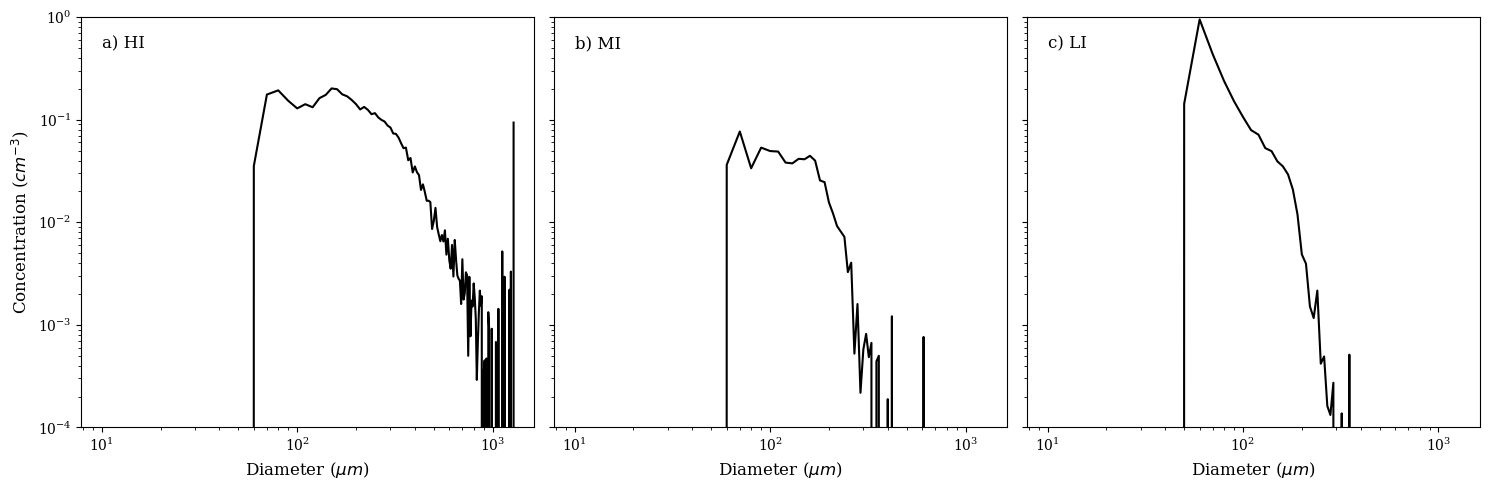

In [74]:
#comb_dic = {'start_time':[], 'end_time':[]}
#print(len(dic_1['start_time']))
#print(len(dic_0['start_time']))
#sliced_data = hi_0.sel(time=slice(dic_0['start_time'][0], dic_0['end_time'][0]))

#slice_av = average.sel(time=slice(av_dic['start_time'][8], av_dic['end_time'][8]))
#av_idx = average.sum(dim = 'time')
#plt.plot(av_idx)

hi = hi_av.sum(dim = 'time')
mi = mi_av.sum(dim = 'time')
li = li_av.sum(dim = 'time')


#plt.xlim(0, 1200)  # Set x limits from 0 to 6
#plt.ylim(0, 1)
font = {'family': 'serif', 'size'   : 10} 
mpl.rc('font', **font)


data = [hi,mi,li]
title = ['HI','MI','LI']
names = ['a) HI','b) MI','c) LI']

plt.figure(figsize = (15,5))
for i in range(3):
    plt.subplot(int(f'13{i+1}'))
    plt.plot(data[i], color = 'black')
    #plt.xlim(10E-1, 10E3)
    plt.ylim(1e-4, 1)
    plt.yscale('log')
    plt.xscale('log')
    #plt.gca().set_title(title[i])
    plt.xlabel('Diameter ($\mu m$)',fontsize=12)
    plt.text(10,0.5,names[i],fontsize=12)

    #plt.ylabel('concentration ($cm^{-3}$)')

    if i == 0:  # Only set ylabel for the leftmost subplot
        plt.ylabel('Concentration ($cm^{-3}$)',fontsize=12)
    else:
        plt.gca().set_yticklabels([],fontsize=12)  # Hide ytick labels for other subplots

plt.tight_layout()
plt.savefig('circularity_comp_30th.png', bbox_inches='tight')


In [12]:
sliced_data

<xarray.DataArray (time: 1490, index: 128)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time     (time) datetime64[ns] 2022-07-30T16:50:59 ... 2022-07-30T17:15:48
  * index    (index) float32 10.0 20.0 30.0 40.0 ... 1.26e+03 1.27e+03 1.28e+03
Attributes:
    _FillValue:              -1e+20
    long_name:               Ambient HI Particle Number per Channel (dN)
    units:                   cm-3
    valid_min:               0.0
    valid_max:               0.13469454496508626
    cell_methods:            time: mean
    category_configuration:  OASIS category table for HI: Min Area = 20.0; Ma...

In [ ]:
#### print(values)
print(values[0])
time = values[0].coords['time']
value = values[0].values

print(value)
print(i)

In [5]:
nc_file.close()

NameError: name 'nc_file' is not defined